### Selecting Physical System and Run with Classical ODE Solve Method (20 pts)

One-dimensional lattice with periodic boundary condition:

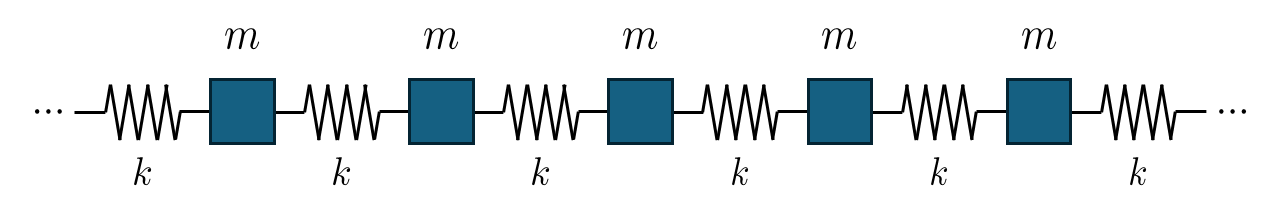

The hamiltonian of the problem is 
\begin{equation*}
H(\mathbf x, \mathbf p) = \sum_{j=0}^{N-1}\frac{p_j^2}{2m_j} + \sum_{j=0}^{N-1}\frac{1}{2}{k_j}(x_j - x_{j+1})^2
\end{equation*}
Where $\mathbf x=(x_0, ..., x_{N-1})$ and $\mathbf p=(p_0, ..., p_{N-1})$ are the canonical position and momentums, $m_0, ..., m_{N-1}$ are the masses of each particle, $k_0, ..., k_{N-1}$ are spring constant between $i$-th and $(i+1)$-th particle and $x_N:=x_0$ (periodic boundary condition).

Although the system it self is exatly solvable via diagonalization, letting $m_0, ..., m_{N-1} = m$ and $k_0, .., k_{N-1} = m\omega_0^2$ gives lattice-translation symmetry and make the system more easier.

In the homogeneous atomic chain, the Hamiltonian and be represented by
\begin{equation*}
H(\mathbf x, \mathbf p) = \frac{1}{2m}\mathbf p^\top\mathbf p + \frac{1}{2}m\omega_0^2\mathbf x^\top \begin{pmatrix}
     2 & -1 &  0 & \cdots &  0 & -1 \\
    -1 &  2 & -1 & \cdots &  0 &  0 \\
     0 & -1 &  2 & \cdots &  0 &  0 \\
    \vdots&\vdots&\vdots&\ddots&\vdots&\vdots\\
     0 &  0 &  0 & \cdots &  2 & -1 \\
    -1 &  0 &  0 & \cdots & -1 & 2 \\ 
\end{pmatrix}
\mathbf x
\end{equation*}

Since the system has lattice-translation symmetry, $H(x_0, x_1, x_2, ..., x_{N-1}, p_0, p_1, p_2, ..., p_{N-1})=H(x_{N-1}, x_0, x_1, ..., x_{N-2}, p_{N-1}, p_0, p_1, ..., p_{N-2})$, the fourier transformation might be helpful. Also, this transformation diagonalize the above matrix.
\begin{gather*}
    X_n = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1} x_j e^{-ik_nj}
    ,\quad
    P_n = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1} p_j e^{ik_nj} \\
    x_n = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1} X_j e^{ik_jn}
    ,\quad
    p_n = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1} P_j e^{-ik_jn}
\end{gather*}
Where $k_n = 2\pi n/N$.

The hamiltonian changes:
\begin{equation*}
    H = \sum_{j=0}^{N} \left(\frac{1}{2m}P_jP_{N-j} + \frac{1}{2}m\omega_j^2X_jX_{N-j}\right) = \sum_{j=0}^{N} \left(\frac{1}{2m}|P_j|^2 + \frac{1}{2}m\omega_j^2|X_j|^2\right)
\end{equation*}
Where $\omega_j = 2\omega_0 |\sin(k_j/2)|$

Hence, the solution is
\begin{align*}
    x_n(t) &= \frac{1}{N}\sum_{j=0}^{N-1}\left[X_j(0)\cos(\omega_jt) + \frac{P_j^*(0)}{m\omega_j}\sin(\omega_jt)\right]e^{ik_j n}\\
    p_n(t) &= \frac{1}{N}\sum_{j=0}^{N-1}\left[-m\omega_j X^*_j(0)\sin(\omega_jt) + P_j(0)\cos(\omega_jt)\right]e^{-ik_j n}
\end{align*}
Where $X_j(0)$ and $P_j(0)$ are the fourier transformation of the initial condition:
\begin{equation*}
    X_n(0) = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} x_j(0)e^{-ik_n j},\quad Q_n(0) = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} p_j(0)e^{ik_n j}
\end{equation*}

In [1]:
import jax
import jax.numpy as jnp
import functools

N = 64
m = jnp.full((N,), 1.)
k = jnp.full((N,), 125.)
c = jnp.sqrt(k / m)

left_shifted = jnp.arange(1, N + 1, dtype=jnp.int32) % N
right_shifted = jnp.arange(-1, N - 1, dtype=jnp.int32) % N

def _kinetic(p, m):
    return jnp.sum(p ** 2) / (2 * m)

def _potential(x, k):
    return (1/2) * k * jnp.sum((x - x[left_shifted]) ** 2)

def _hamiltonian(x, p, m, k):
    return _kinetic(p, m) + _potential(x, k)

kinetic = jax.jit(_kinetic)
potential = jax.jit(_potential)
hamiltonian = jax.jit(_hamiltonian)

t0 = 0
t1 = 20
dt0 = 1e-2

# INITIAL CONDITIONS
amp = 2
loc = 31
sigma = 3

def gaussian_envelope(x, amp, loc, sigma):
    return amp * (1 / jnp.sqrt(2 * jnp.pi * sigma ** 2)) * jnp.exp(-((x - loc) ** 2) / (2 * sigma ** 2))

x0 = jnp.zeros((N,))
p0 = jnp.zeros((N,))

indices = jnp.arange(-3 * sigma + loc, 3 * sigma + loc + 1, 1, dtype=jnp.int32) % N
dx = gaussian_envelope(jnp.linspace(-3 * sigma, 3 * sigma, 6 * sigma + 1), amp, 0, sigma)
dp = (m[indices] * c[indices] / (sigma ** 2)) * (jnp.linspace(-3 * sigma, 3 * sigma, 6 * sigma + 1)) * dx

x0 = x0.at[indices].add(dx)
p0 = p0.at[indices].add(dp)

x0 = x0 - jnp.mean(x0)
p0 = p0 - jnp.mean(p0)

# ODE FUNCTION
def _grad_kinetic(p, m):
    return p / m

def _grad_potential(x, k):
    return k * (2 * x - x[left_shifted] - x[right_shifted])

grad_kinetic = jax.jit(_grad_kinetic)
grad_potential = jax.jit(_grad_potential)

@jax.jit
def f(t, z, args):
    x, p = z
    m, k = args
    return (_grad_kinetic(p, m), -_grad_potential(x, k))

# analytic solution
@jax.jit
@functools.partial(jax.vmap, in_axes=(0, None, None, None, None)) # vectorize over t
def get_analytic_sol(t, x0, p0, m, k):
    x0 = jnp.asarray(x0)
    p0 = jnp.asarray(p0)
    N = len(x0)
    
    omega0 = jnp.sqrt(k / m)
    
    indices = jnp.arange(N)
    momentums = 2 * jnp.pi * indices / N
    omegas = 2 * omega0 * jnp.abs(jnp.sin(momentums/2))
    
    # Fourier transform of initial conditions
    X0 = jnp.fft.fft(x0, norm='ortho')
    P0 = jnp.fft.ifft(p0, norm='ortho')
    
    tol = 1e-12
    
    # vibration modes
    Xt_vib = X0 * jnp.cos(omegas * t) + (jnp.conj(P0) / (m * omegas)) * jnp.sin(omegas * t)
    Pt_vib = -m * omegas * jnp.conj(X0) * jnp.sin(omegas * t) + P0 * jnp.cos(omegas * t)
    
    # translation modes
    Xt_trans = X0 + (jnp.conj(P0) / m) * t
    Pt_trans = P0
    
    Xt = jnp.where(omegas < tol, Xt_trans, Xt_vib)
    Pt = jnp.where(omegas < tol, Pt_trans, Pt_vib)

    
    xt = jnp.fft.ifft(Xt, norm='ortho')
    pt = jnp.fft.fft(Pt, norm='ortho')
    
    return jnp.real(xt), jnp.real(pt)

defining and initializing ODE

In [2]:
import diffrax # library for ODE solving
# SELECTED CLASSICAL METHOD FOR SOLVING ODE


# defingg the ODE term
term = diffrax.ODETerm(f)


# ODE Solving method is Dormand-Prince's 8/7 method, 8th order Explicit Runge-Kutta method.
solver = diffrax.Dopri8() 


# save the solution at 60 points per unit time. this not related to the step size.
saveat = diffrax.SaveAt(ts = jnp.linspace(t0, t1, int((t1 - t0) * 60) + 1)) 


# take the step size adaptively by PID controller keeping the error tolerance relative=1e-6, absolute=1e-6. 
stepsize_controller = diffrax.PIDController(rtol=1e-6, atol=1e-6) 



In [3]:
import time

# SOLVE ODE
start = time.time()
sol = diffrax.diffeqsolve(term, solver, t0=t0, t1=t1, dt0=dt0, y0=(x0, p0), saveat=saveat, args=(m, k),
                          stepsize_controller=stepsize_controller)
time_typical = time.time() - start

ts = sol.ts
xs, ps = sol.ys

print(f"typical ODE integration approach take {time_typical} seconds") # including jit compilation time

typical ODE integration approach take 2.0817904472351074 seconds


In [4]:
from arrow import get
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
# VISUALIZATION

def make_video(t, xs, ps, output_path, fps=60):
    num_frames = len(t)
    index = np.arange(N)

    x = xs[0]
    p = ps[0]

    fig, ax = plt.subplots(figsize=(8, 5))

    ax.plot(index, x, label='$x$')
    ax.plot(index, p, label='$p$')
    ax.set_xticks(index)
    ax.set_xlabel('Particle indices')
    ax.set_ylabel('displacement')
    ax.set_title(f't={t[0]:.2f}')
    ax.set_ylim(-2, 2)
    ax.legend()

    def update(frame):
        t = ts[frame]
        x = xs[frame]
        p = ps[frame]
        
        ax.lines[0].set_ydata(x)
        ax.lines[1].set_ydata(p)
        
        ax.set_title(f't={t:.2f}')

    writer = FFMpegWriter(fps=fps, metadata=dict(artist='Me'), bitrate=1800)
    with writer.saving(fig, output_path, dpi=100):
        for frame in tqdm.trange(num_frames, desc="making video"):
            update(frame)
            writer.grab_frame()
    
    plt.close(fig)
    
from IPython.display import Video

video_path = "./output.mp4"

make_video(ts, xs, ps, video_path) # it takes about 1 minute
Video(video_path, embed=True)

making video: 100%|██████████| 1201/1201 [01:17<00:00, 15.59it/s]


### Run with Simple NN (20pts)

In [ ]:
import equinox as eqx # library for neural networks
# SELECTED NEURAL NETWORK FOR SOLVING ODE

class Network(eqx.Module):
    phase_net: eqx.nn.Linear
    sine_net: eqx.nn.Linear
    cosine_net: eqx.nn.Linear
    translation_net: eqx.nn.Linear
    
    def __init__(self, key):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        self.phase_net = eqx.nn.Linear(1, N, key=key1)
        self.sine_net = eqx.nn.Linear(N, 2 * N, use_bias=False, key=key2)
        self.cosine_net = eqx.nn.Linear(N, 2 * N, use_bias=False, key=key3)
        self.translation_net = eqx.nn.Linear(1, 2 * N, key=key4)
        
    def __call__(self, t):
        phases = self.phase_net(t)
        cosines = jnp.cos(phases)
        sines = jnp.sin(phases)
        z = self.cosine_net(cosines) + self.sine_net(sines) + self.translation_net(t)
        return (z[:N], z[N:])

residual function:

In [6]:
from functools import partial
# DEFINE RESIDUAL FUNCTION

vectorized_grad_kinetic = jax.vmap(partial(grad_kinetic, m=m))
vectorized_grad_potential = jax.vmap(partial(grad_potential, k=k))

@jax.jit
@jax.value_and_grad
def residual(model, t, x0, p0):
    pred_x, pred_p = jax.vmap(model)(t)
    pred_dxdt, pred_dpdt = jax.vmap(jax.jacobian(model))(t)
    
    equation_res = jnp.mean((jnp.squeeze(pred_dxdt) - vectorized_grad_kinetic(pred_p))**2)  \
                 + jnp.mean((jnp.squeeze(pred_dpdt) + vectorized_grad_potential(pred_x))**2)
    
    initial_x = pred_x[0]
    initial_p = pred_p[0]
    initial_res = jnp.mean((initial_x - x0)**2) + jnp.mean((initial_p - p0)**2)
    return equation_res + initial_res

In [5]:
# DATASET GENERATION

t_dataset = jnp.linspace(t0, t1, int((t1 - t0) * 60) + 1)[:, jnp.newaxis]

In [ ]:
import optax # library for optimization

# TRAINING NEURAL NETWORK


# initial conditions



# initialize the model and optimizer
initialization_key = jax.random.PRNGKey(1234)
model_key, twkey, tbkey = jax.random.split(initialization_key, 3)
_model = Network(model_key)

sigma = 1e-7
initial_weight = jax.random.normal(twkey, (2 * N, 1)) * sigma
initial_bias = jax.random.normal(tbkey, (2 * N,)) * sigma
where = lambda model: (model.translation_net.weight, model.translation_net.bias)
model = eqx.tree_at(where, _model, (initial_weight, initial_bias))

# hyperparameters
learning_rate = 1e-3
n_epochs = 50000
clip_value = 1

# Optax Optimizer
schedule = optax.piecewise_constant_schedule(
    init_value=1e-3,
    boundaries_and_scales={500: 0.1, 4200: 0.5, 12000: 0.2, 30000: 0.5}
)
optimizer = optax.chain(
    optax.clip_by_global_norm(clip_value),
    optax.adam(schedule)
)
opt_state = optimizer.init(model)


losses = np.empty((n_epochs,))
gradnorms = np.empty((n_epochs,))

# train loop
for epoch in range(n_epochs):
    loss, grads = residual(model, t_dataset, x0, p0)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)

    # saveing logs
    grad_norm = jnp.sqrt(sum([jnp.sum(jnp.square(x)) for x in jax.tree_util.tree_leaves(grads)]))
    losses[epoch] = loss
    gradnorms[epoch] = grad_norm

    if epoch % 50 == 0:
        print(f"Epoch ({epoch}): loss = {loss}, grad_norm = {grad_norm}")

Epoch (0): loss = 28419.630859375, grad_norm = 101234.0390625
Epoch (50): loss = 26.822185516357422, grad_norm = 853.0908813476562
Epoch (100): loss = 3.786428213119507, grad_norm = 759.7332763671875
Epoch (150): loss = 3.963970899581909, grad_norm = 1208.6136474609375
Epoch (200): loss = 2.089487075805664, grad_norm = 686.1654663085938
Epoch (250): loss = 1.192117691040039, grad_norm = 625.7369384765625
Epoch (300): loss = 2.1185433864593506, grad_norm = 1514.1502685546875
Epoch (350): loss = 1.7775598764419556, grad_norm = 1200.3023681640625
Epoch (400): loss = 1.5185036659240723, grad_norm = 1119.2939453125
Epoch (450): loss = 1.6064763069152832, grad_norm = 1059.273193359375
Epoch (500): loss = 1.5593698024749756, grad_norm = 1014.76171875
Epoch (550): loss = 0.3301893174648285, grad_norm = 56.48530578613281
Epoch (600): loss = 0.29120898246765137, grad_norm = 82.80101013183594
Epoch (650): loss = 0.24208655953407288, grad_norm = 56.5200309753418
Epoch (700): loss = 0.2136500179767

### Analysis Classical Method and Deep Learning Based Method (30pts)

YOUR SELECTED ANALYSIS METHOD (OR ANALYSIS PARAMETERS) EXPLANATION HERE (in markdown)

In [27]:
# ANALYSIS

# typical ODE solver: 
# exact sol과 비교

ts = sol.ts
xs, ps = sol.ys
start = time.time()
xs_exact, ps_exact = get_analytic_sol(ts, x0, p0, m, k)
time_exact = time.time() - start
print(f"calculating analytic solution takes {time_exact} seconds") # including jit compilation time
mean_square_error = jnp.mean((xs - xs_exact)**2, axis=1) + jnp.mean((ps - ps_exact)**2, axis=1)
max_error = jnp.max(jnp.concatenate([jnp.abs(xs - xs_exact), jnp.abs(ps - ps_exact)], axis=1), axis=1)

# step size vs error
dt0s = [1e-2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5, 3e-6, 1e-6]
def solve_eqn_with_given_dt0(dt0, solver=diffrax.Dopri5(), t0=0, t1=20, y0=(x0, p0), args=(m, k)):
    term = diffrax.ODETerm(f)
    saveat = diffrax.SaveAt(ts = jnp.linspace(t0, t1, int((t1 - t0) * 10) + 1)) # save 10 points per unit time
    stepsize_controller = diffrax.ConstantStepSize() # explicitly choose ConstantStepSize
    start = time.time()
    sol = diffrax.diffeqsolve(term, solver, t0=t0, t1=t1, dt0=dt0, y0=y0, saveat=saveat, args=args,
                            stepsize_controller=stepsize_controller, max_steps=None)
    elapsed_time = time.time() - start
    xs, ps = sol.ys
    x, p = xs[-1], ps[-1]
    x_exact, p_exact = get_analytic_sol(jnp.asarray([sol.ts[-1]]), x0, p0, m, k)
    error = jnp.sqrt(jnp.sum((x - x_exact) ** 2) + jnp.sum((p - p_exact) ** 2))
    print(elapsed_time, error)
    return elapsed_time, error.item()
    
data_eular = [solve_eqn_with_given_dt0(dt0, solver=diffrax.Euler()) for dt0 in dt0s]
data_dopri5 = [solve_eqn_with_given_dt0(dt0) for dt0 in dt0s]
print(data_dopri5)

# method vs speed
methods = {
    # "Eular": diffrax.Euler(),
    "Midpoint": (diffrax.Midpoint(), 2),
    "Bosh3": (diffrax.Bosh3(), 3),
    "Tsit5": (diffrax.Tsit5(), 5),
    "Dopri5": (diffrax.Dopri5(), 5),
    "Dopri8": (diffrax.Dopri8(), 7),
    "ImplicitEuler": (diffrax.ImplicitEuler(), 1),
    "Kvaerno3": (diffrax.Kvaerno3(), 3),
    "Kvaerno5": (diffrax.Kvaerno5(), 5),
}
def solve_eqn_with_given_method(solver, t0=0, t1=200, y0=(x0, p0), args=(m, k)):
    term = diffrax.ODETerm(f)
    saveat = diffrax.SaveAt(ts = jnp.linspace(t0, t1, int((t1 - t0) * 10) + 1)) # save 10 points per unit time
    stepsize_controller = diffrax.PIDController(rtol=1e-6, atol=1e-6) # PID controller
    start = time.time()
    sol = diffrax.diffeqsolve(term, solver, t0=t0, t1=t1, dt0=1e-3, y0=y0, saveat=saveat, args=args,
                            stepsize_controller=stepsize_controller, max_steps=None)
    elapsed_time = time.time() - start
    xs, ps = sol.ys
    x, p = xs[-1], ps[-1]
    x_exact, p_exact = get_analytic_sol(jnp.asarray([sol.ts[-1]]), x0, p0, m, k)
    error = jnp.sqrt(jnp.sum((x - x_exact) ** 2) + jnp.sum((p - p_exact) ** 2))
    return elapsed_time, error.item()

data = [(name, order, solve_eqn_with_given_method(solver)) for name, (solver, order) in methods.items()]
print(data)
# error_bound = sol.
# loss 플롯롯

calculating analytic solution takes 0.0 seconds
[(0.021510839462280273, 4.4039974454790354e-05), (0.6814899444580078, 5.0344024202786386e-05), (0.1774299144744873, 6.173691508593038e-05), (1.326585292816162, 9.364184370497242e-05), (2.0319952964782715, 0.00018661362992133945), (7.2077860832214355, 0.0009920563315972686), (19.051487922668457, 0.004898296669125557), (61.521745920181274, 0.029897626489400864), (175.96542382240295, 0.1264462023973465)]
[('Midpoint', 2, (2.0924901962280273, 0.006374587770551443)), ('Bosh3', 3, (1.5732910633087158, 0.03268224373459816)), ('Tsit5', 5, (2.2347757816314697, 0.022828487679362297)), ('Dopri5', 5, (1.9138517379760742, 0.01873619854450226)), ('Dopri8', 7, (1.6436872482299805, 0.006221851799637079)), ('ImplicitEuler', 1, (24.248387336730957, 1.4220376014709473)), ('Kvaerno3', 3, (12.6761634349823, 0.00717040803283453)), ('Kvaerno5', 5, (5.2195210456848145, 0.025127708911895752))]


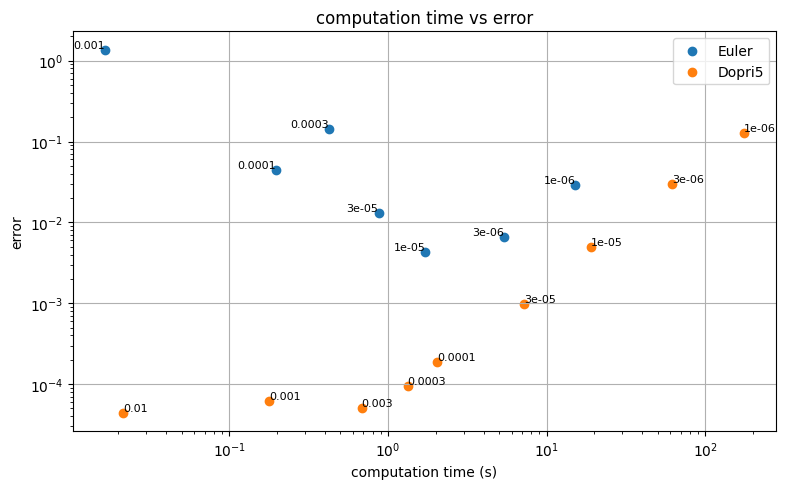

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.title("computation time vs error")

dt0s = [1e-2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5, 3e-6, 1e-6]

# For Euler, note we use dt0s[1:] (since data_eular[0] is skipped)
euler_times, euler_errors = zip(*data_eular[2:])
plt.scatter(euler_times, euler_errors, label="Euler")
for time_val, error_val, dt in zip(euler_times, euler_errors, dt0s[2:]):
    plt.text(time_val, error_val, f"{dt}", fontsize=8, ha="right", va="bottom")

# For Dopri5
dopri5_times, dopri5_errors = zip(*data_dopri5)
plt.scatter(dopri5_times, dopri5_errors, label="Dopri5")
for time_val, error_val, dt in zip(dopri5_times, dopri5_errors, dt0s):
    plt.text(time_val, error_val, f"{dt}", fontsize=8, ha="left", va="bottom")

plt.xscale('log')
plt.yscale('log')

plt.xlabel("computation time (s)")
plt.ylabel("error")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


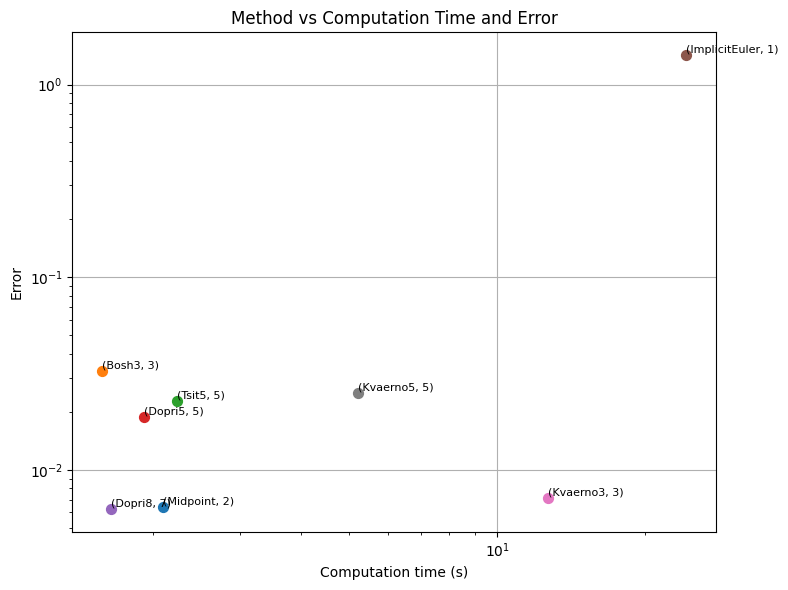

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.title("Method vs Computation Time and Error")

# iterate over data and plot each point with caption as (method name, order)
for name, order, (time_val, error_val) in data:
    plt.scatter(time_val, error_val, s=50)
    plt.text(time_val, error_val, f"({name}, {order})", fontsize=8, ha="left", va="bottom")

plt.xlabel("Computation time (s)")
plt.ylabel("Error")
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()

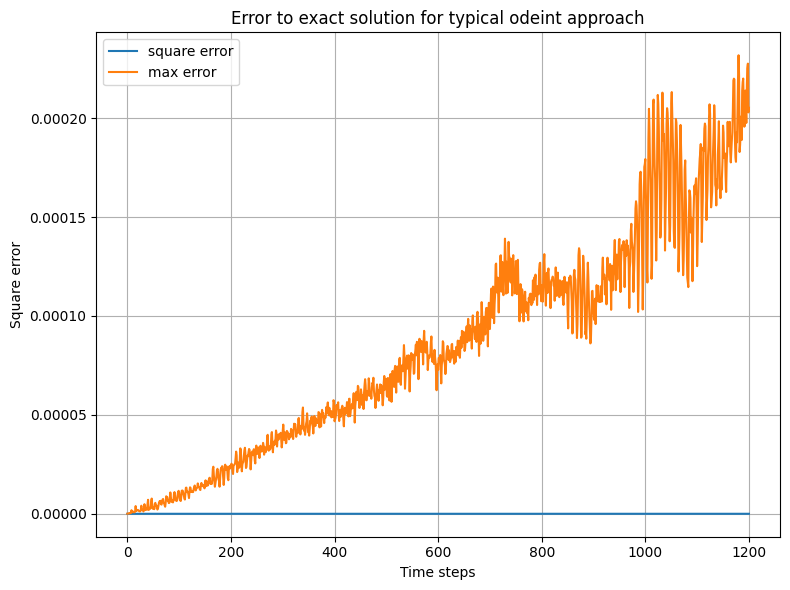

NameError: name 'losses' is not defined

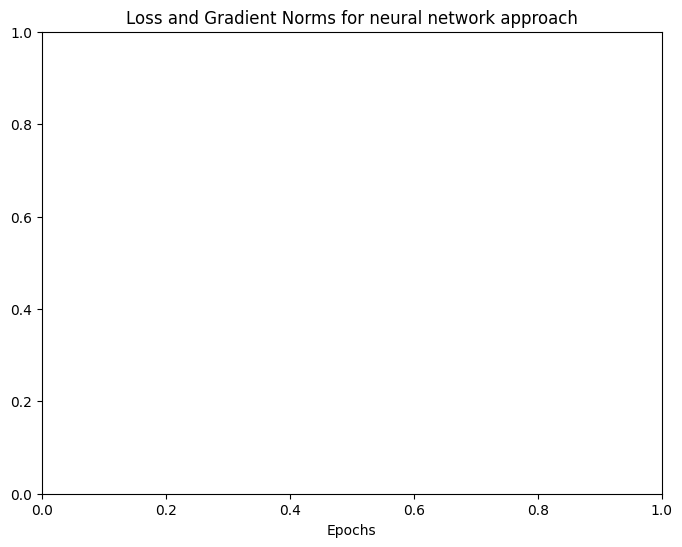

In [29]:
# VISUALIZATION
plt.figure(figsize=(8, 6))
plt.title('Error to exact solution for typical odeint approach')
plt.plot(mean_square_error, label='square error')
plt.plot(max_error, label='max error')

plt.xlabel("Time steps")
plt.ylabel("Square error")
# plt.yscale('log')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
plt.title('Loss and Gradient Norms for neural network approach')
plt.xlabel("Epochs")
plt.plot(losses, label='loss')
plt.plot(gradnorms, label='gradnorm')   
plt.yscale('log')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Discuss the results (30pts)

DISCUSSING THE ANALYSIS RESULTS (in 200 words)

### 기존 수치해석 방법
  8-th order Explicit Runge-Kutta method인 Dormand-Prince's 8/7 method를 이용하여 미분방정식을 적분했으며,
  stepsize의 경우 PID controller를 이용해 오차의 절대적인 값과 오차의 증감을 동시에 이용해 적정 stepsize를 효율적으로 찾았다.
  20초 시뮬레이션에 대략 1초가 걸렸다.

  실제 Analytic solution과 비교해도 큰 오차가 없었으며 step 수가 늘어날 수록 오차가 누적되어 선형적으로 증가했다. 최대 $10^{-4}$ 정도의 오차만 있었다.


  step size와 사용하는 method를 바꾸며 오차 크기와 계산 시간간의 관계를 조사했다.

  - step size 변화
    step size를 아래와 같이 변화시켜가며 계산시간 vs 최종 오차를 플롯했다.
    $$[1\times 10^{-2}, 3\times 10^{-3}, 1\times 10^{-3}, 3\times 10^{-4}, 1\times 10^{-4}, 3\times 10^{-5}, 1\times 10^{-5}, 3\times 10^{-6}, 1\times 10^{-6}]$$
    Eular method의 경우 $1\times 10^{-2}, 3\times 10^{-3}$ 두 케이스의 경우 발산했고, 대략 $10^-5$까지는 computation time이 늘어나는 대신 오차도 대략 같이 감소했으나, 그 이후로는 오차가 오히려 증가했다. 계산에 사용한 float32자료형의 정밀도 한계(유효숫자 7개)를 넘었을 것으로 추정된다.

    반면 5차 명시적 Runge-Kutta방법인 Dormand-Prince's 5 method를 사용했을 때는, step을 적게 쪼개도 오히려 오차가 증가하기만 했다. 대신 Eular method가 발산한 $1\times 10^{-2}$에서 Eular method의 오차 최솟값보다 더 좋은 성능을 보였다.


  - method별 성능
    비슷한 tolerance를 얻기 위해 얼마나 많은 계산이 필요한지 비교하기 위해 step size를 PIDController를 이용해 조절하도록 두고 여러 method를 사용해 비교했다.
    Stiff하지 않은 문제인 만큼 explicit method가 implicit method에 비해 계산 속도 측면에서 유리했다.

    가장 고차 방법인 Dormand-Prince's 8/7 방법(계산에 8차, 오차 추정 및 adaptive step을 위해 7차방법을 같이 사용)이 최종 오차, 속도 면에서 가장 좋았다. 한 step당 시간은 오래걸리지만, 낮은 오차로 stepsize를 다른 방법에 비해 크게 잡을 수 있었을 것이다.

    Implicit Eular method의 경우 implicit한 방법임에도, 1차 방법의 한계로 200초 동안의 긴 시뮬레이션동안 오차가 누적되어 analytic solution에서 크게 벗어났다.

### Neural Network를 이용한 접근
  
  실제 해가 가지는 꼴에 기반한 (삼각함수의 선형결합) Neural Network를 설계하고, Residual function을 loss로 하여 학습을 진행.
  loss가 $5 \times 10^{-3}$ 정도로 수렴했지만 실제 Analytic solution과 아주 다른 결과를 보임.


  - NN모델 학습에서 발생한 문제들
    처음에는 파라미터가 발산해 제대로 학습되지 않음.
    이후 로그를 통해 gradient가 너무 크다는것을 확인, gradient clipping을 통해 해결.
    하지만 이후 학습 속도가 너무 느림(10000 epoch 이후에도 수렴하지 않음) 따라서 Optimizer를 Gradient Descent에서 Adam으로 변경.
    Adam을 사용하니 학습 속도가 빨라지고, Loss가 5배 이상 더 잘 수렴했지만 그래도 loss가 1미만으로 효과적으로 줄어들지 않음.
    learning rate를 $10^-3$에서 시작해 500, 4200, 12000, 30000지점에서 각각 $1/10, 1/2, 1/5, 1/2$씩 감소하도록 함. 더 낮은 loss를 달성했지만, 원하는 해로 수렴하지 않음.
    결과적으로 시뮬레이션을 원하는 system이 너무 크고, loss에 local minima가 많아 학습이 어려운 것으로 보임.

    
  - 작은 System에서 Learning rate vs convergence
    
